In [ ]:
# Let's try torch, the right py-kernel is python (myenv) and the env in conda is called ENVvae2, 
# more details can be found in the meeting notes with Lukas may 3


In [ ]:
# this is the tutorial: https://www.kaggle.com/code/schmiddey/variational-autoencoder-with-pytorch-vs-pca
# based on tabular data

In [1]:
import torch
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.0.0


In [2]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import sklearn as sk

In [4]:
df = pd.read_csv(r"/Users/karolinagustavsson/Code/Python_VAE/NH3.csv")

print(df)

         sampleID  year  wave  gender  age  annual_income  income_recode  \
0          1991_3  1991     0       1   21            NaN            2.0   
1          1991_4  1991     0       2   32            NaN            8.0   
2          1991_9  1991     0       2   48            NaN            8.0   
3         1991_10  1991     0       1   35            NaN            8.0   
4         1991_11  1991     0       1   48            NaN            6.0   
...           ...   ...   ...     ...  ...            ...            ...   
18820  1991_53593  1991     0       1   23            NaN            6.0   
18821  1991_53594  1991     0       2   26            NaN            6.0   
18822  1991_53595  1991     0       1   32            NaN            5.0   
18823  1991_53616  1991     0       1   85            NaN            3.0   
18824  1991_53618  1991     0       2   79            NaN            2.0   

       education  edu  ethnicity  ...  status  ucod_leading  diabetes  \
0            3

In [5]:
# Preparing the data

# apparently you have to restart and clear output 
# Define the columns of interest
columns_of_interest = ["sampleID", "status", "albumin", "alp", "lymph", "mcv",
                       "lncreat", "lncrp", "hba1c", "wbc", "rdw", "age"]

# Select only the necessary columns
df = df[columns_of_interest]

# Remove rows with any missing values
df = df.dropna()

# Keep the ID and status columns separate if needed later
ids = df['sampleID']
status = df['status']

# Remove these from the dataframe to be normalized
df = df.drop(['sampleID', 'status'], axis=1)

from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Normalize the data
data_normalized = scaler.fit_transform(df)

# Optionally convert back to DataFrame
df_normalized = pd.DataFrame(data_normalized, columns=df.columns)

from sklearn.model_selection import train_test_split

# Splitting data
x_train, x_test = train_test_split(df_normalized, test_size=0.2, random_state=123)
x_train, x_val = train_test_split(x_train, test_size=0.25, random_state=123)

# Check the shapes of the resulting data splits
print("Train data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

print(df_normalized.describe())
print(x_train.head())

In [6]:
### Wine notebook: https://www.kaggle.com/code/schmiddey/variational-autoencoder-with-pytorch-vs-pca

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

########################## ändra
def load_data(path):
    # read in from csv
    df = pd.read_csv(DATA_PATH, sep=',', header=None, names=['Wine', 'Alcohol','Malic.acid','Ash','Acl',
                                                    'Mg', 'Phenols', 'Flavanoids','Nonflavanoid.phenols',
                                                    'Proanth','Color.int','Hue', 'OD','Proline'])
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    # get wine Label
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer, df_wine

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_data(path):
    # Load the dataset
    df = pd.read_csv(path)
    
    # Define the columns of interest
    columns_of_interest = ["sampleID", "status", "albumin", "alp", "lymph", "mcv",
                           "lncreat", "lncrp", "hba1c", "wbc", "rdw", "age"]
    
    # Select only the necessary columns
    df = df[columns_of_interest]
    
    # Remove rows with any missing values
    df = df.dropna()

    # Separate out IDs and status, and keep them for later use
    ids = df['sampleID']
    status = df['status']
    ages = df['age'].values
    
    # Remove the ID and status columns from the dataframe to be normalized
    df_normalized = df.drop(['sampleID', 'status'], axis=1)
    
    # Normalize the data
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(df_normalized)
    
    # Convert normalized data back into a DataFrame with appropriate column names
    df_normalized = pd.DataFrame(x_normalized, columns=df_normalized.columns)
    
    # Return the normalized data and scaler, along with IDs and status for reintegration later
    return df_normalized, scaler, ids, status, ages

# Example usage
DATA_PATH = '/Users/karolinagustavsson/Code/Python_VAE/NH3.csv'
x_train, standardizer, train_ids, train_status, ages = load_data(DATA_PATH)


In [10]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class DataBuilder(Dataset):
    def __init__(self, path):
        # Load the data and ignore IDs and status for training purposes
        self.x, self.standardizer, self.ids, self.status, self.ages = load_data(path)
        # Convert the dataframe to a PyTorch tensor
        self.x = torch.tensor(self.x.values, dtype=torch.float32)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        # Return the tensor at the specified index
        return self.x[index]

    def __len__(self):
        return self.len

### this messes something up: , self.status[index]
import torch
from torch.utils.data import Dataset, DataLoader

class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.ids, self.status = load_data(path)
        self.x = torch.tensor(self.x.values, dtype=torch.float32)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        # Also return the status
        return self.x[index], self.status[index]

    def __len__(self):
        return self.len

In [12]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024, shuffle=False) ### Here we added shuffle false

In [13]:
type(trainloader.dataset.x)

torch.Tensor

In [14]:
data_set.x

tensor([[ 1.4982,  0.2133,  0.3334,  ..., -0.2466, -0.8054, -1.3980],
        [-0.1006,  0.1032, -0.4331,  ...,  2.5606, -0.0608, -0.8349],
        [-0.3671, -0.9979, -0.0613,  ..., -1.0555, -1.1033, -0.0159],
        ...,
        [ 1.7647,  0.9106, -1.2798,  ...,  0.3006,  0.1378, -1.2956],
        [-0.3671, -0.5942,  1.5805,  ..., -0.9603,  0.8328, -1.1421],
        [ 0.4323,  1.9749, -0.1586,  ..., -0.2942,  0.5349,  1.8782]])

In [15]:
### Build model and train it
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # when the forward method is called, the decode method's output is the reconstructed batch (recon_batch), and 
        #the outputs mu and logvar are the parameters of the latent distribution used for sampling
        return self.decode(z), mu, logvar
    

In [16]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [17]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [18]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
loss_mse = customLoss()

In [20]:
### Train model
epochs = 150
log_interval = 50
val_losses = []
train_losses = []

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [22]:
for epoch in range(1, epochs + 1):
    train(epoch)

In [23]:
### Evaluate
standardizer = trainloader.dataset.standardizer

In [24]:
model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

standardizer.inverse_transform(recon_batch[65].cpu().numpy())

In [25]:
standardizer.inverse_transform(recon_batch[65].cpu().numpy().reshape(1,-1))

array([[ 4.223924  , 71.92024   , 43.128468  , 89.41029   ,  0.605919  ,
         0.23006457,  5.1169653 ,  5.4564986 , 12.736299  , 33.311054  ]],
      dtype=float32)

standardizer.inverse_transform(data[5].cpu().numpy())

In [26]:
standardizer.inverse_transform(data[65].cpu().numpy().reshape(1, -1))

array([[ 4.1       , 55.        , 48.9       , 94.6       ,  0.51879376,
         0.19062035,  5.        ,  4.55      , 12.7       , 26.999998  ]],
      dtype=float32)

In [27]:
### Get embeddings / latent variables
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [28]:
mu_result.shape

torch.Size([15122, 3])

In [29]:
mu_result[1:5,:]

tensor([[ 1.8245,  0.0297, -0.6896],
        [-0.3316, -0.0052, -0.2475],
        [-0.2130, -0.0176, -1.1710],
        [-0.3793, -0.0097,  1.9409]])

In [30]:
### Plot embeddings of VAE
#ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
#winetype = data_set.wine
#zdata = mu_result[:,0].cpu().numpy()
#xdata = mu_result[:,1].cpu().numpy()
#ydata = mu_result[:,2].cpu().numpy()
#ax.scatter3D(xdata, ydata, zdata, c=winetype);

So now it works but it is time to make a 2.0 version 

mu_output = []

model.eval()
with torch.no_grad():
    for data in trainloader:
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        mu_output.append(mu.cpu().numpy())  # Collect mu outputs

mu_result = np.concatenate(mu_output, axis=0)  # Concatenate all outputs

In [31]:
mu_output = []
decoded_output = []

model.eval()
with torch.no_grad():
    for data in trainloader:
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        mu_output.append(mu.cpu().numpy())  # Collect mu outputs
        decoded_output.append(recon_batch.cpu().numpy())  # Collect decoded outputs

# Concatenate all outputs
mu_result = np.concatenate(mu_output, axis=0)
decoded_data = np.concatenate(decoded_output, axis=0)

# Reverse the scaling transformation on decoded data
original_decoded_data = standardizer.inverse_transform(decoded_data)

# Assuming the age column is the last column in your preprocessed data
decoded_ages = original_decoded_data[:, -1]  # Adjust this index based on where age is in your array


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

latent_dim = mu_result.shape[1]  # Number of latent dimensions

for i in range(latent_dim):
    model = LogisticRegression()
    model.fit(mu_result[:, i:i+1], train_status)  # Fit model for each latent variable
    predictions = model.predict(mu_result[:, i:i+1])
    print(f'Latent Variable {i+1}:')
    print(classification_report(train_status, predictions))


Latent Variable 1:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     11883
         1.0       0.00      0.00      0.00      3239

    accuracy                           0.79     15122
   macro avg       0.39      0.50      0.44     15122
weighted avg       0.62      0.79      0.69     15122

Latent Variable 2:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     11883
         1.0       0.00      0.00      0.00      3239

    accuracy                           0.79     15122
   macro avg       0.39      0.50      0.44     15122
weighted avg       0.62      0.79      0.69     15122

Latent Variable 3:
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87     11883
         1.0       0.50      0.19      0.27      3239

    accuracy                           0.79     15122
   macro avg       0.65      0.57      0.57     15122
weighted avg     

/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Warning: /opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Indicates: This indicates that for at least one class, there were no predicted samples, and as such, metrics like precision, recall, and F-score cannot be calculated (dividing by zero issue). By default, sklearn sets these metrics to 0.0 in such cases.

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


Latent Variable 1:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     11883
         1.0       0.00      0.00      0.00      3239

    accuracy                           0.79     15122
   macro avg       0.39      0.50      0.44     15122
weighted avg       0.62      0.79      0.69     15122

AUC for Latent Variable 1: 0.5923

Latent Variable 2:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     11883
         1.0       0.00      0.00      0.00      3239

    accuracy                           0.79     15122
   macro avg       0.39      0.50      0.44     15122
weighted avg       0.62      0.79      0.69     15122

AUC for Latent Variable 2: 0.6230

Latent Variable 3:
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87     11883
         1.0       0.50      0.19      0.27      3239

    accuracy                           0.79     15122
 

/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

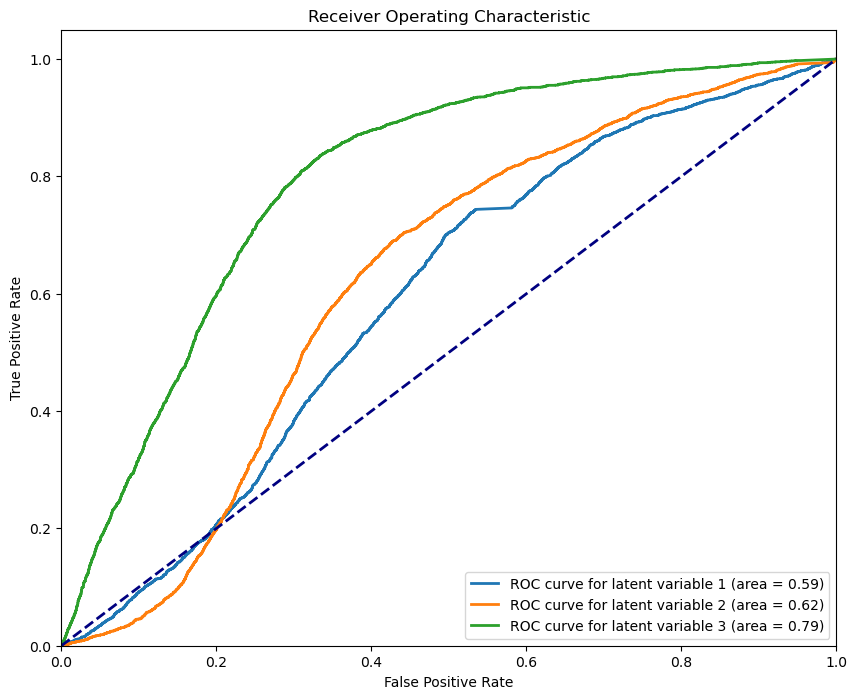

In [34]:
# Assuming mu_result and train_status are already defined
latent_dim = mu_result.shape[1]  # Get the number of latent dimensions

# Create a figure to hold the plots
plt.figure(figsize=(10, 8))

for i in range(latent_dim):
    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(mu_result[:, i:i+1], train_status)
    
    # Predict probabilities for the positive class
    probas_ = model.predict_proba(mu_result[:, i:i+1])[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(train_status, probas_)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2,
             label=f'ROC curve for latent variable {i+1} (area = {roc_auc:.2f})')

    # Print classification report and AUC
    print(f'Latent Variable {i+1}:')
    print(classification_report(train_status, model.predict(mu_result[:, i:i+1])))
    print(f"AUC for Latent Variable {i+1}: {roc_auc_score(train_status, probas_):.4f}\n")

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

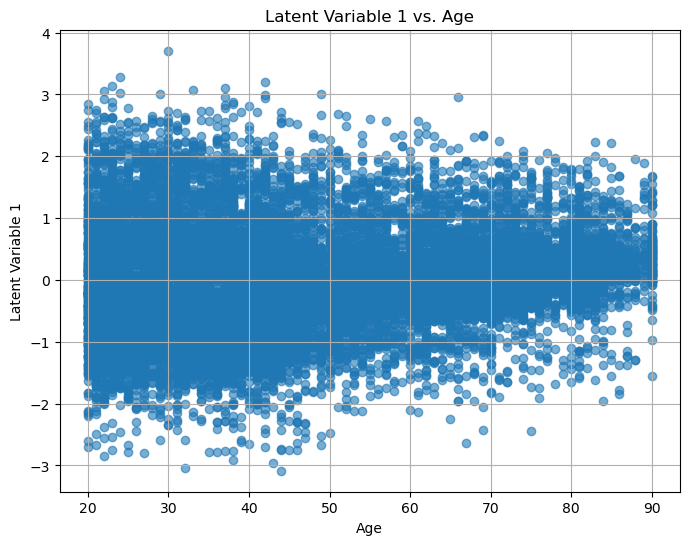

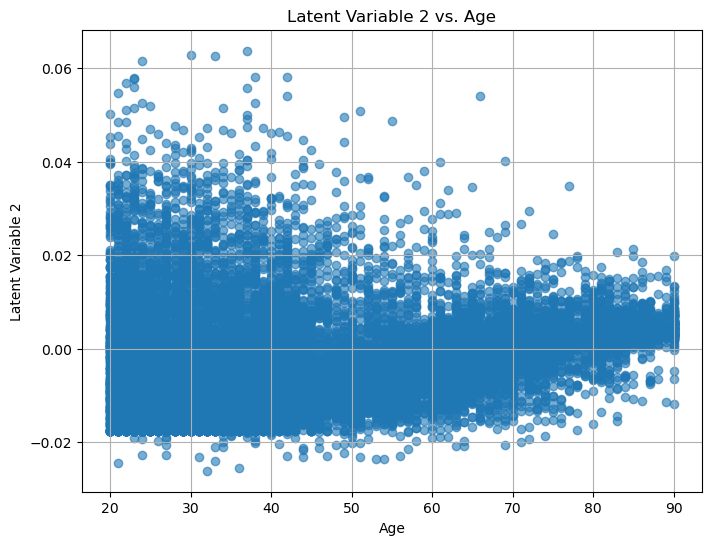

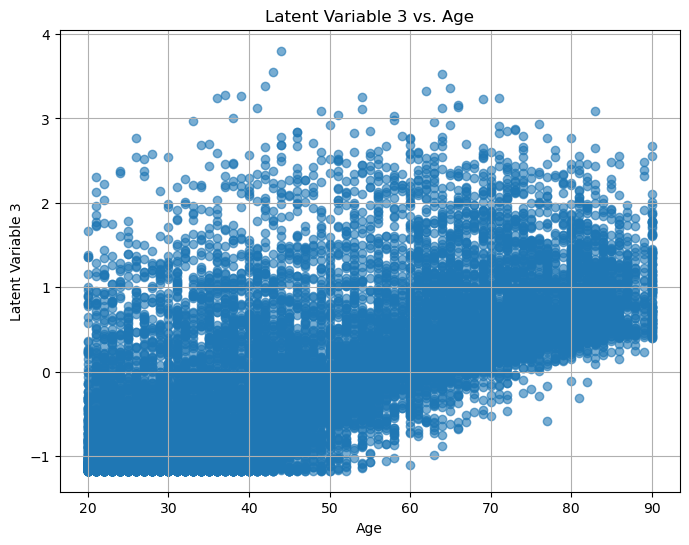

In [35]:
import matplotlib.pyplot as plt

# Assuming mu_result is available and contains the latent variables for your data
latent_dim = mu_result.shape[1]  # Number of latent dimensions

for i in range(latent_dim):
    plt.figure(figsize=(8, 6))
    plt.scatter(ages, mu_result[:, i], alpha=0.6)
    plt.title(f'Latent Variable {i+1} vs. Age')
    plt.xlabel('Age')
    plt.ylabel(f'Latent Variable {i+1}')
    plt.grid(True)
    plt.show()

In [36]:
import numpy as np
from scipy.stats import pearsonr

for i in range(latent_dim):
    correlation, _ = pearsonr(mu_result[:, i], ages)
    print(f'Correlation between Latent Variable {i+1} and Age: {correlation:.3f}')


Correlation between Latent Variable 1 and Age: 0.121
Correlation between Latent Variable 2 and Age: 0.086
Correlation between Latent Variable 3 and Age: 0.654


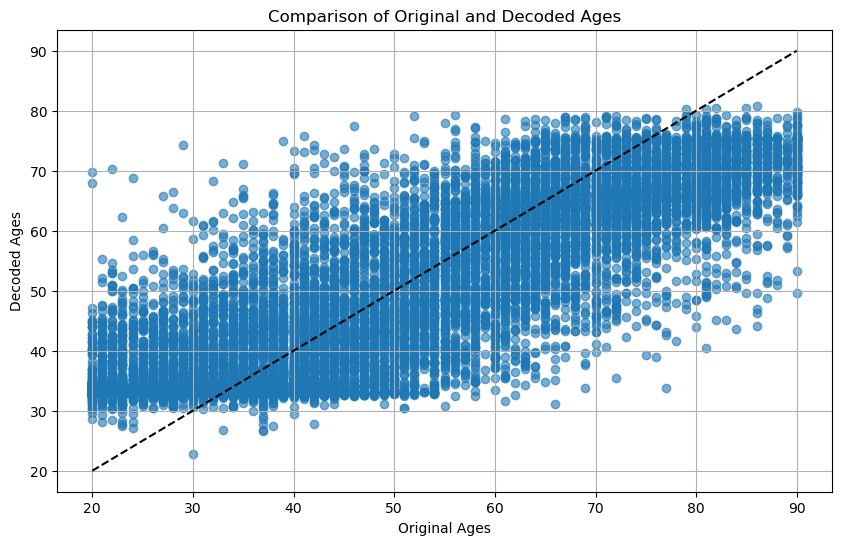

In [37]:
import matplotlib.pyplot as plt

# Assuming `ages` is the array of original ages you extracted when loading the data
plt.figure(figsize=(10, 6))
plt.scatter(ages, decoded_ages, alpha=0.6)
plt.title('Comparison of Original and Decoded Ages')
plt.xlabel('Original Ages')
plt.ylabel('Decoded Ages')
plt.plot([ages.min(), ages.max()], [ages.min(), ages.max()], 'k--')  # Line showing perfect reconstruction
plt.grid(True)
plt.show()